# Algorithmic Trading using Technical Analysis
by Chee-Foong

## Summary
This analysis attempts to build a machine learning model to generate buy/sell trading signals of an investible asset based on technical indicators like momentum, volatility, trends, etc.  

A couple of machine learning models are built.  Random Forest, LightLGM, XGBoost to name a few and finally using crowd wisdom VotingClassifer to consolidate all the trading signals.

Each model is trained, cross validated and tuned using historical data before 1 Jan 2020 and then forward tested on unseen data after 1 Jan 2020.  Trading performance is shown at the end of this analysis.

## Trading Instrument
Cryptocurrency BTCUSD is the trading instrument picked for this analysis.

## Data
*To register your own API key to assess the Binance API.*  

1-min OHLC prices to be downloaded using Binance API.  Prices will be resampled at 15-min intervals for model training.

## Machine Learning
### Multiclassification Models
1. Random Forest
2. LightGBM
3. XGBoost
4. Gradient Boosting Trees
5. Voting Classifier

### Features
1. Technical Indicators
2. Candlestick Patterns
3. Historical Return

### Target Label
Next hourly return broken down into 3 buckets:
1. **Red**: Next Hourly Return < -0.015
2. **Yellow**: Next Hourly Return between -0.015 to 0.015
3. **Green**: Next Hourly Return > 0.015

## Trading Strategy
The model predicts with probability where the next hourly return will be one of the 3 possible targets: Green, Yellow and Red.  Under unbiased random sampling, each target should have a probability of 33.33%.  One can consider taking a trade when the model predicts with a probability greater than 33.33%.

Hence,
1. Trade the instrument when the model predicts with probability of at least 45%.  **Green** to go long and **Red** to go short.
2. Hold and close the position after exactly 1 hour.

## Forward Testing
Trading strategy testing on unseen forward data.  Performance of each trade is consolidated and measured against a benchmark which is the performance of the trading instrument over the same period.

## Useful Libraries
1. [Binance REST API python implementation](https://pypi.org/project/python-binance/)
2. [Technical Analysis Library in Python](https://pypi.org/project/ta/)
3. [Hurst exponent evaluation and R/S-analysis](https://pypi.org/project/hurst/)

## Reference
1. [How to Use Binance API Key | Full Guide](https://cryptopro.app/help/automatic-import/binance-api-key/)
2. [Technical Analysis Library in Python](https://github.com/bukosabino/ta)
3. [Python wrapper for TA-Lib](https://github.com/mrjbq7/ta-lib)
4. [An unofficial mirror to the old SF repo](https://github.com/TA-Lib)

In [100]:
# !pip3 install --upgrade ta
# !pip3 install python-binance

---
## Initialisation

In [101]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# IMPORTS
import pandas as pd
import numpy as np

import time
import math
import os.path

from tqdm.notebook import tqdm

from datetime import timedelta, datetime
from dateutil import parser

# Import the plotting library
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import MonthLocator

import seaborn as sns
sns.set()

## Changing the default settings
pd.options.display.max_columns = 50
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

In [102]:
from ta import add_all_ta_features
from ta.utils import dropna

In [103]:
import sys  
sys.path.append('../src') 

from edge_binance import *
from edge import *
from edge_risk_kit import *
import edge_risk_kit as erk

## Connect to Binance

Create your own API keys to download prices from Binance.

In [104]:
import json

with open('../binance/api.json', 'r') as f:
    api = json.load(f)

In [105]:
binance_api_key = api['key']       # Enter your own API-key here
binance_api_secret = api['secret'] # Enter your own API-secret here

DATA_FOLDER = '../data/'
MODEL_FOLDER = '../model/'
OUTPUT_FOLDER = '../output/'

createfolder(DATA_FOLDER)
createfolder(MODEL_FOLDER)
createfolder(OUTPUT_FOLDER)

bClient = binanceClient(binance_api_key, binance_api_secret, DATA_FOLDER)

## Download Data

Specify the list of cryptocurrency tickers to download data.

In [106]:
coins = ['BTCUSDT', 'ETHUSDT']

In [107]:
for symbol in tqdm(coins):
    try:
        bClient.get_all_binance(symbol, '1m', save = True)
    except:
        print('Skipping {}...'.format(symbol))
        pass

  0%|          | 0/2 [00:00<?, ?it/s]

All caught up..!
All caught up..!


---
## Data Preprocessing

1. Remove any records with the same timestamp.  Keeping to the last one.
2. Resample the 1-min data into 15-min data.  OHLC sampled with the latest data.  Volume sampled by summing all the values within the hour.
3. Reindex the sampled data with timestamp and specify the timezone to match with the trading timezone.

In [108]:
prices = pd.read_csv('../data/BTCUSDT-1m-data.csv', parse_dates=True)

In [109]:
prices = prices.iloc[prices.timestamp.drop_duplicates(keep='last').index]
prices.timestamp = pd.to_datetime(prices.timestamp)
prices.set_index('timestamp', inplace=True)

prices_ohlc = prices[['open','high','low','close']]
prices_vol = prices[['volume']]

prices_ohlc = prices_ohlc.resample('15T').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
prices_vol = prices_vol.resample('15T').sum()

prices_ohlc.fillna(method='ffill', inplace=True)

prices = pd.concat([prices_ohlc, prices_vol], axis=1)

In [110]:
prices.index = prices.index.tz_localize('UTC').tz_convert('Asia/Singapore')

---
## Feature Engineering
### Technical Indicators

In [111]:
prices_ind = prices.copy()

In [112]:
# from ta import add_all_ta_features

# # Add all ta features
# prices_ind = add_all_ta_features(prices_ind, open="open", high="high", low="low", close="close", volume="volume")

In [113]:
# prices_ind.loc[:,(prices_ind.isnull().mean() * 100).sort_values(ascending=False) > 0].columns

#### Momentum Indicators
1. Relative Strength Index (RSI)
2. Rate of Change (ROC)
3. Williams %R (WR)

In [114]:
from ta.momentum import RSIIndicator, ROCIndicator, WilliamsRIndicator

prices_ind['rsi14'] = RSIIndicator(prices.close).rsi()
prices_ind['roc12'] = ROCIndicator(prices.close).roc()
prices_ind['wr14'] = WilliamsRIndicator(prices.high, prices.low, prices.close).williams_r()

#### Trend Indicators
1. Moving Average Convergence Divergence (MACD)
2. Average Directional Movement Index (ADX)

In [115]:
from ta.trend import CCIIndicator, MACD, ADXIndicator
import talib

# prices_ind['cci20'] = CCIIndicator(prices.high, prices.low, prices.close).cci()
prices_ind['adx'] = ADXIndicator(prices.high, prices.low, prices.close).adx()
prices_ind['macd'] = MACD(prices.close).macd()
prices_ind['macd_diff'] = MACD(prices.close).macd_diff()
prices_ind['macd_signal'] = MACD(prices.close).macd_signal()

#### Volatility Indicators

1. Bollinger Bands (BB): Crossover Upper
2. Bollinger Bands (BB): Crossover Lower
3. Average True Range (ATR)

In [116]:
from ta.volatility import AverageTrueRange, BollingerBands

prices_ind['atr'] = AverageTrueRange(prices.high, prices.low, prices.close).average_true_range()
prices_ind['bb_high'] = BollingerBands(prices.close).bollinger_hband_indicator()
prices_ind['bb_low'] = BollingerBands(prices.close).bollinger_lband_indicator()

### Candlestick Patterns

Using TA Library to detect and generate candlestick patterns.  See list of Pattern Recognition here: (https://github.com/mrjbq7/ta-lib)

In [117]:
import talib

candle_names = talib.get_function_groups()['Pattern Recognition']
removed = ['CDLCOUNTERATTACK', 'CDLLONGLINE', 'CDLSHORTLINE', 
           'CDLSTALLEDPATTERN', 'CDLKICKINGBYLENGTH']
candle_names = [name for name in candle_names if name not in removed]

In [118]:
# extract OHLC 
op = prices_ind['open']
hi = prices_ind['high']
lo = prices_ind['low']
cl = prices_ind['close']

# create columns for each pattern
for candle in candle_names:
    # below is same as;
    # df["CDL3LINESTRIKE"] = talib.CDL3LINESTRIKE(op, hi, lo, cl)
    prices_ind[candle] = getattr(talib, candle)(op, hi, lo, cl)

### Miscellaneous

#### Candle Features
1. Body Size: Close - Open
2. Length of hair: High - max(Open, Close) 
3. Length of tail: min(Open, Close) - Low

In [119]:
prices_ind['hair'] = prices.apply(lambda x: x.high - max(x.open, x.close), axis=1)
prices_ind['body'] = prices.close - prices.open
prices_ind['tail'] = prices.apply(lambda x: min(x.open, x.close) - x.low, axis=1)

#### Other Features

1. Hourly Return - Using 15-min price data to calculate the cumulative hourly return (4 candle sticks)

In [120]:
# from statsmodels.tsa.stattools import adfuller
# from hurst import compute_Hc, random_walk
# prices_ind['adfuller'] = prices.close.rolling(192).apply(lambda x: adfuller(x)[0])
# prices_ind['hurst'] = prices.close.rolling(192).apply(lambda x: compute_Hc(x)[0])

prices_ind['pct_chg'] = (prices.close.pct_change()+1).rolling(4).apply(np.prod)-1

### Target

1. Next Hourly Return - Shift back the hour return 4 candlesticks to be used as target on the features observed at that point in time.

In [121]:
prices_ind['target'] = prices_ind['pct_chg'].shift(-4)

### Features not required
Dropping OHLC from the training features.  Not expecting these to have strong prediction power.

In [122]:
data = prices_ind.iloc[:,4:].dropna()

### Target Classification
Binning next hourly return into 3 distinct groups:
- Red: Hourly return < -0.015
- Green: Hourly return > 0.015
- Yellow: the rest

Name of target column: **target_range**

In [123]:
target_range = {0: 'Red', 1: 'Yellow', 2: 'Green'}
target_range_rev = {val:key  for key, val in target_range.items()}

In [124]:
data['target_range'] = pd.cut(data['target'], 
       bins=[-float("inf"),-0.015,0.015,float("inf")], 
       right=False, labels=['Red','Yellow','Green'])

In [125]:
data['target_range'] = data['target_range'].map(target_range_rev)

---
## Model Data Preparation
### Train Test Split

Model training with data before 1 Jan 2020.  Data after 31 Dec 2019 will be use as out-of-sample (forward looking) trading performance measurement at the end of this analysis.

The training data is further split into train and validation dataset (80% vs 20%) for model training with hyperparameter tuning and cross validation.

In [126]:
SEED = 3567

In [127]:
target = ['target_range']
to_drop = ['target']
features = [column for column in data.columns if column not in target + to_drop]

X = data[:'2019'][features]
y = data[:'2019'][target]

X_sim = data['2020':][features]
y_sim = data['2020':][target + to_drop]

In [128]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, 
                                                      stratify=y, random_state=SEED)

### Normalising the datasets
- Fit and Transform on the train dataset
- Transform only on the validation dataset using the scaler fitted with train dataset
- Such scaling or normalising may not be necessary for tree-based models

In [129]:
numerical_cols = ['volume','rsi14','roc12','wr14','macd','macd_diff','macd_signal',
                  'adx','atr','bb_high','bb_low','hair','body','tail','pct_chg']

In [130]:
col_toscale = [col for col in X_train.columns.tolist() if col in numerical_cols]
print('List of columns to scale: {}'.format(col_toscale))

List of columns to scale: ['volume', 'rsi14', 'roc12', 'wr14', 'adx', 'macd', 'macd_diff', 'macd_signal', 'atr', 'bb_high', 'bb_low', 'hair', 'body', 'tail', 'pct_chg']


In [131]:
def processStdScaler(train, valid, columns):
    
    train_scaled = train.copy()
    valid_scaled = valid.copy()

    scaler = StandardScaler()
    scaler.fit(train[columns])
    train_scaled[columns] = scaler.transform(train[columns])
    valid_scaled[columns] = scaler.transform(valid[columns])

    return train_scaled, valid_scaled, scaler

In [132]:
X_train_std, X_valid_std, scaler = processStdScaler(X_train, X_valid, col_toscale)

In [133]:
X_train = X_train_std
X_valid = X_valid_std

Save the scaler for prediction next time

In [135]:
import pickle 

scaler_pkl = open(MODEL_FOLDER + 'scaler.pkl', 'wb') 
pickle.dump(scaler, scaler_pkl)

### Resampling the Training dataset
Resampling is only done on the training dataset due to imbalanced target variable.  Upsampling will be done and be only conducted after the training dataset is normalised.

In [138]:
y_train.groupby('target_range').size()

target_range
0     2970
1    60662
2     2888
dtype: int64

In [139]:
y_train.target_range.value_counts()

1    60662
0     2970
2     2888
Name: target_range, dtype: int64

In [140]:
from sklearn.utils import resample

def upsample_byCol(data, column, code):
    maxN = data.groupby(column).size().max()

    df = data[data[column] == code]
    num = maxN - df.shape[0]
    if num > 0:
        df_more = resample(df, replace=True, n_samples=num, random_state=SEED)
        df = pd.concat([df, df_more])
    return df

In [141]:
Xy_train = pd.concat([X_train, y_train], axis = 1)

In [142]:
train_resample = []

return_ranges = Xy_train['target_range'].unique()
for return_range in return_ranges:
    code_resampled = upsample_byCol(Xy_train, 'target_range', return_range)
    train_resample.append(code_resampled)
    
Xy_train = pd.concat(train_resample).reset_index(drop=True)
Xy_train = Xy_train.sample(frac=1, random_state = SEED).reset_index(drop=True)

In [143]:
Xy_train.groupby('target_range').size()

target_range
0    60662
1    60662
2    60662
dtype: int64

In [144]:
target = ['target_range']
to_drop = ['']
features = [column for column in Xy_train.columns if column not in target + to_drop]

X_train = Xy_train[features]
y_train = Xy_train[target]

X_valid = X_valid[features]
y_valid = y_valid[target]

In [145]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train.target_range), 
#                                                   np.array(y_train.target_range))
# class_weights

### Prepare Training and Validation dataset for GridSearch

This will have to be done separately because we need the grid search to tune the parameters by validating against a dataset we provide and not automatically sampled from the training dataset that has been resampled.  We want samples in the validation dataset to be unseen in the training dataset.

In order to do this properly for GridSearchCV, we need to use PredefinedSplit and fit GridSearchCV with the full dataset.  The test dataset is further splitted into 3 groups for validation scoring calculation.  Note however that this may cause a longer model training time.

In [146]:
Xy_trainGS = X_train.join(y_train)
Xy_validGS = X_valid.join(y_valid)

grpTest = np.random.randint(3, size=Xy_validGS.shape[0])

In [147]:
from sklearn.model_selection import PredefinedSplit

# Create a list where train data indices are -1 and validation data indices are 0
# eg: split_index = [-1 if x in X_train.index else 0 for x in X.index]
# split_index = [-1] * Xy_trainGS.shape[0] + [0] * Xy_validGS.shape[0] 
split_index = [-1] * Xy_trainGS.shape[0] + list(grpTest)

# Use the list to create PredefinedSplit
pds_GridSearch = PredefinedSplit(test_fold = split_index)

In [148]:
# for train_index, test_index in pds_GridSearch.split():
#     print("TRAIN:", train_index, "TEST:", test_index, len(test_index))

In [149]:
Xy_GS = pd.concat([Xy_trainGS, Xy_validGS]).reset_index(drop=True) 
X_GS = Xy_GS[features]
y_GS = Xy_GS[target]

### Finalising the Datasets

We have 3 datasets.  They are the train, valid and GS datasets.  GS is the full dataset with in which the preDefinedSplit indices are defined for cross validation purpose used especially for hyperparameter tuning during GridSearch.  Each dataset is further separated by features (X) and target (y).  

Also, keeping a copy of the validation target dataframe to be appended with model prediction results and confusion matrix presentation and summary.

In [150]:
X_valid_org = X_valid.copy()
y_valid_org = y_valid.copy()

In [151]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_GS.shape)
print(y_GS.shape)

(181986, 71)
(181986, 1)
(16631, 71)
(16631, 1)
(198617, 71)
(198617, 1)


---
## Model Training

In [152]:
from lightgbm import LGBMClassifier, plot_importance, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, ShuffleSplit, cross_validate

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error 

### Quick Test
A quick model test, just to ensure the training dataset is constructed and transformed correctly for model training.

In [153]:
# evaluate the model
lgbm = LGBMClassifier()

n_scores = cross_val_score(lgbm, X_GS, y_GS, scoring='accuracy', cv=pds_GridSearch, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.754 (0.006)


### Model Building
#### Hyperparameter tuning for various models

- Light GBM
- Random Forest
- Gradient Boosting Classifier
- XGBoost

In [154]:
n_estimators = [150]  # Large estimators will increase the training time
max_features = [0.6, 0.8]
max_depth = [9, 12]
learning_rate = [0.005, 0.001]
subsample = [0.6, 0.8]
gamma = [0.01]
num_leaves = [10, 12]

In [155]:
models = []
grid_param = []

# lgbm
models.append(('lgbm', LGBMClassifier()))
grid_param.append([{ 
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'n_estimators': n_estimators,
        'num_leaves': num_leaves,
#         'reg_alpha': alpha_l1,
#         'reg_lambda': lambda_l2,
        'subsample': subsample,
        'colsample_bytree': max_features,
        'random_state': [SEED]  
    }])

# rf
models.append(('rf', RandomForestClassifier()))
grid_param.append([{ 
        'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'max_samples': subsample,
        'criterion': ['gini', 'entropy'],
        'oob_score': [True],
        'random_state': [SEED]
    }])

## gb
models.append(('gb', GradientBoostingClassifier()))
grid_param.append([{ 
        'n_estimators': n_estimators,
        'subsample': subsample,
        'max_features': max_features,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'random_state': [SEED]
    }])

## xgb
models.append(('xgb', XGBClassifier()))
grid_param.append([{ 
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'n_estimators': n_estimators,
        'gamma': gamma,
#         'reg_alpha': alpha_l1,
#         'reg_lambda': lambda_l2,
        'subsample': subsample,
        'colsample_bytree': max_features,
        'seed': [SEED]  
    }])


This process can take a long time to find the best parameters for each model.  As this is a multi-class classification problem, the scoring metric of **roc_auc_ovr** is used.  'ovr' stands for One-vs-Rest.  This metric is sensitive to class imbalance.

In [156]:
from sklearn.model_selection import GridSearchCV

In [ ]:
start_total = time.perf_counter()

savefolder = MODEL_FOLDER + getTimeStamp() + '/'
createfolder(savefolder)

for model, param in zip (models, grid_param):

    print(model[1])
    print(param)
    
    start = time.perf_counter()        
    best_search = GridSearchCV(estimator=model[1], param_grid=param, 
                               cv=pds_GridSearch, scoring='roc_auc_ovr', 
                               verbose=0, return_train_score=True)
    
    best_search.fit(X_GS, y_GS)
    
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('\n######')
    print('The best parameter for {} is {} with a runtime of {:.2f} minutes.'.format(model[1].__class__.__name__, 
                                                                                     best_param, run/60))
    model[1].set_params(**best_param) 
    print('######\n')
    
    save_ml_model(model, savefolder + model[0] + '.pkl')
    
run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

The hyperparameter tuning took a total of 632 minutes on my machine.  That is almost 10.5 hours.  GradientBoostingClassifier took the longest and completed after 426 minutes. 

In [ ]:
from tqdm import tqdm_notebook as tqdm

model_results = []
for m in tqdm(models):
    result = {}
    print('Processing {}...'.format(type(m[1]).__name__))

    m_cv = cross_validate(m[1], X_GS, y_GS, cv=pds_GridSearch, return_train_score=True)
#     m_cv = cross_validate(m[1], X_GS, y_GS, cv=3, return_train_score=True)
    
    result['Model'] = type(m[1]).__name__
    result['TrainScore'] = m_cv['train_score'].mean()
    result['TestScore'] = m_cv['test_score'].mean()
    result['Test3Std'] = m_cv['test_score'].std()*3
    
    model_results.append(result)

#### Including Voting Classifier

Using Crowd Wisdom

In [ ]:
## Including Voting Classifier in the results    
## Hard Vote or majority rules w/Tuned Hyperparameters

print('Processing VotingClassifer...')
result = {}    
vc = VotingClassifier(estimators=models, voting='soft')
vc_cv = cross_validate(vc, X_GS, y_GS, cv=pds_GridSearch, return_train_score=True)
# vc_cv = cross_validate(vc, X_GS, y_GS, cv=3, return_train_score=True)

result['Model'] = type(vc).__name__
result['TrainScore'] = vc_cv['train_score'].mean()
result['TestScore'] = vc_cv['test_score'].mean()
result['Test3Std'] = vc_cv['test_score'].std()*3

model_results.append(result)

In [ ]:
models.append(('vc', vc))

In [ ]:
model_results = pd.DataFrame(model_results).set_index('Model').sort_values('TestScore', ascending=False) 
model_results

### Save Models

In [ ]:
savefolder = MODEL_FOLDER + getTimeStamp() + '/'
createfolder(savefolder)

for m in models:
    save_ml_model(m, savefolder + m[0] + '.pkl')

Reloading the pretrained model for reproducibility reasons.

In [157]:
models = []
for f in getFilelist(MODEL_FOLDER + '20210401124401'):
    if f.endswith('.pkl'):
        models.append(load_ml_model(f))

### Model Selection
Choosing the best performing model.  XGBClassifier is choosen here because the test score is relatively high with low volatility test result.

In [158]:
for i, v in enumerate(models):
    print(i, v[0])

0 gb
1 lgbm
2 rf
3 vc
4 xgb


Finalising the best model by refitting with all the training data.

In [159]:
best = models[4][1]
# best = vc
best.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.01, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.005, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=3567, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=3567, subsample=0.6,
              tree_method=None, validate_parameters=False, verbosity=None)

Save the best model for prediction next time

In [160]:
save_ml_model(best, MODEL_FOLDER + 'best_model.pkl')

### Feature Importance of best model

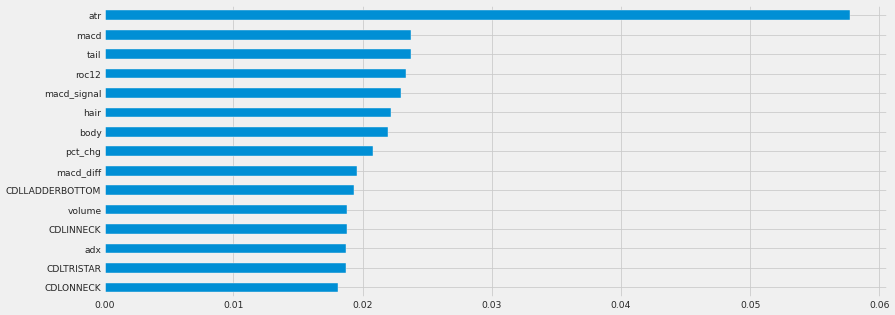

In [161]:
if type(best).__name__ == 'LGBMClassifier':
    plot_importance(best, max_num_features=15)
    plt.show()
elif type(best).__name__ == 'VotingClassifier':
    pass
else:
    feat_importances = pd.Series(best.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(15).plot(kind='barh').invert_yaxis()
    plt.show()

The top technical indicators are:
1. **atr**: Average True Range
2. **macd**: 12-day EMA - 26-day EMA
3. **roc12**: Rate of Change (ROC)  
4. **macd_signal**: 9-day EMA of MACD Line

It is interesting to note that the shape of the candlestick: hair, tail and body contributes significantly to model prediction.

## Model Performance

In [162]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [163]:
predicted = best.predict(X_valid)
y_valid_org['predicted_range'] = predicted

In [164]:
class_labels = [target_range[key] for key in list(set(y_valid_org['target_range'].to_list() + 
                                                      y_valid_org['predicted_range'].to_list()))]

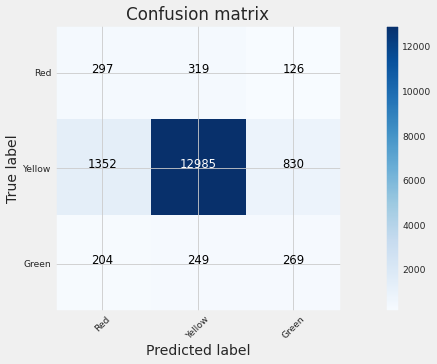

In [165]:
confusion = confusion_matrix(y_valid_org['target_range'], y_valid_org['predicted_range'])
plot_confusion_matrix(confusion, class_labels, False)
plt.show()

### Selecting predictions with higher probability thresholds

Predictions with at least 45% probability of getting it right given 3 choices of Green, Yellow and Red.

In [166]:
predicted_prob = best.predict_proba(X_valid)
predicted_prob = np.amax(predicted_prob,1)
y_valid_org['predicted_prob'] = predicted_prob
# y_valid_org.predicted_prob.max()

In [167]:
PROB_THRESHOLD = 0.45

In [168]:
high_prob = y_valid_org[y_valid_org.predicted_prob > PROB_THRESHOLD]

In [169]:
class_labels = [target_range[key] for key in list(set(high_prob['target_range'].to_list() + 
                                                      high_prob['predicted_range'].to_list()))]

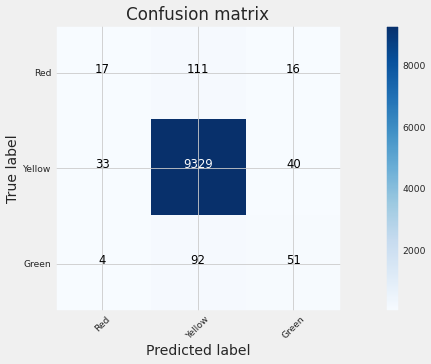

In [170]:
confusion = confusion_matrix(high_prob['target_range'], high_prob['predicted_range'])
plot_confusion_matrix(confusion, class_labels, False)
plt.show()

## Trading Performance

Using out-of-sample (forward looking) data after 1 Jan 2020 to make a prediction and execute a trade according to signal predictions.  


X_sim contains feature data beyond 1 Jan 2020.  It needs to be normalised using the scaler trained on training data before it can be applied to the trained model for prediction.

In [171]:
X_sim_scaled = X_sim.copy()
X_sim_scaled[col_toscale] = scaler.transform(X_sim_scaled[col_toscale])

In [172]:
predicted = best.predict(X_sim_scaled)
predicted_proba = best.predict_proba(X_sim_scaled)
predicted_proba = np.amax(predicted_proba,1)

In [173]:
model_results = y_sim.copy()
model_results['predicted'] = predicted
model_results['predicted_proba'] = predicted_proba

Only taking trades when the model predicts either Green or Red with a probability of at least 45%.

In [174]:
trade_perf = model_results[(predicted_proba > PROB_THRESHOLD) & (predicted != 1)]
trade_perf['long'] = trade_perf.apply(lambda x: x.predicted == 2, axis=1)
trade_perf['ret'] = trade_perf.apply(lambda x: x.target if x.long else -x.target, axis=1)

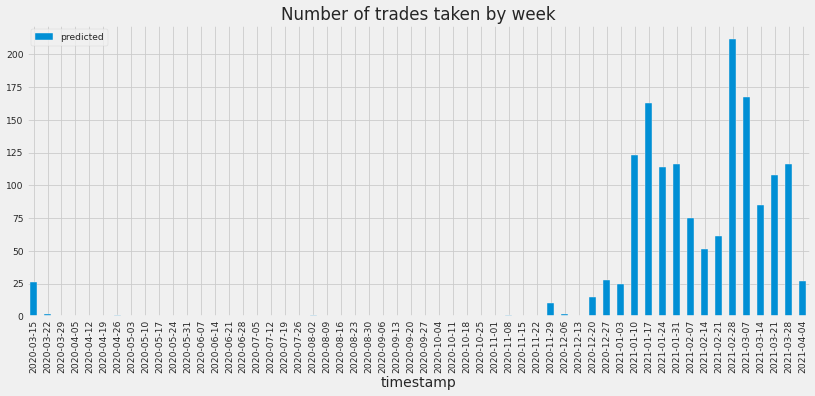

In [175]:
data = trade_perf.resample('1W').agg({'predicted':'size'})
data.index = data.index.tz_localize(None)
data = data.to_period('D')
data.plot(kind='bar', title='Number of trades taken by week')
plt.show()

Observed that the model initiated more trades starting late 2020 and picked up early 2021 when the cryptocurrencies are bubblish with extraordinary returns.

In [176]:
trade_perf = trade_perf.reindex(model_results.index)
trade_perf.ret.fillna(0, inplace=True)
trade_perf['cum_return'] = ((1 + trade_perf['ret']).cumprod()-1)

### Performance Comparison

Comparing the trading portfolio performance against the benchmark.  The benchmark in this case is the underlying cryptocurrency in which the model is to trade.  

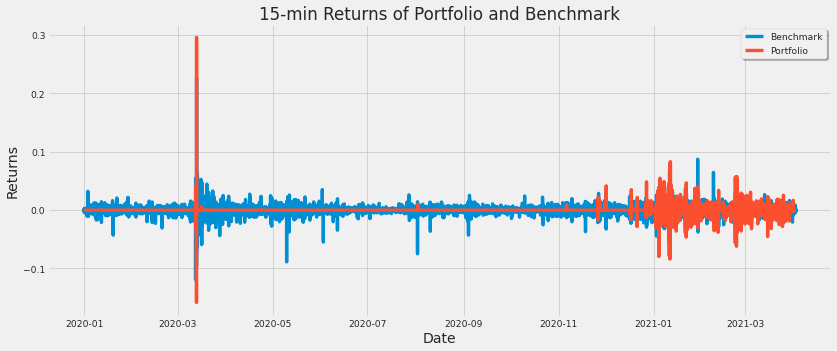

In [177]:
fig, ax = plt.subplots()
ax.plot(prices.close['2020':].pct_change().dropna(), label='Benchmark')
ax.plot(trade_perf.ret, label='Portfolio')

ax.legend(shadow=True)
ax.set_xlabel('Date')
ax.set_ylabel('Returns')
ax.set_title('15-min Returns of Portfolio and Benchmark')

plt.show()

As expected, there are quiet periods between Mar 2020 to Nov 2020 in which the model made no trades.

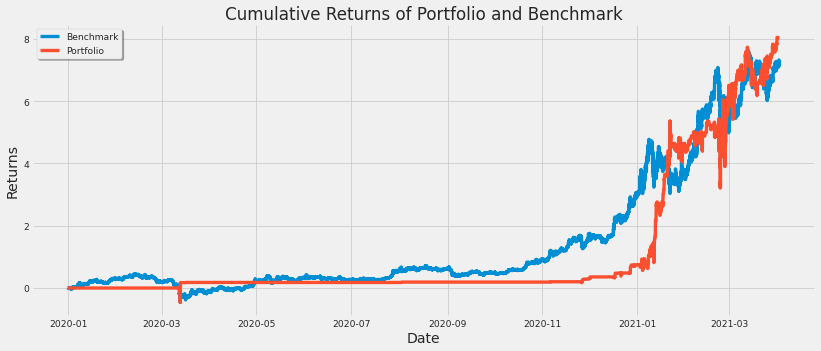

In [178]:
fig, ax = plt.subplots()
ax.plot((1 + prices.close['2020':].pct_change().dropna()).cumprod()-1, label='Benchmark')
ax.plot(trade_perf.cum_return, label='Portfolio')

ax.legend(shadow=True)
ax.set_xlabel('Date')
ax.set_ylabel('Returns')
ax.set_title('Cumulative Returns of Portfolio and Benchmark')

plt.show()

The model managed to catch up with the benchmark early 2021.  4-5 months after the benchmark began its appreciation.  This is understandable because the model was being trained on lagging technical indicators.  Signals triggered are delayed.  Still the portfolio managed to match the benchmark cumulative performance.

In [179]:
portf_bmk = prices.close['2020':].pct_change().dropna().to_frame()
portf_bmk = portf_bmk.join(trade_perf.ret)
portf_bmk.columns = ['Benchmark','Portfolio']
portf_bmk.dropna(inplace=True)

RISK_FREE_RATE = 0.02
PERIODS_PER_YEAR = 4 * 24 * (252+52)

erk.summary_stats(portf_bmk, riskfree_rate=RISK_FREE_RATE, periods_per_year=PERIODS_PER_YEAR).sort_values('Sharpe Ratio', ascending=False)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Portfolio,3.316524,0.638955,20.541128,1820.253207,-0.182551,0.000171,5.058090,-0.474825
Benchmark,3.068476,0.779114,1.893942,190.818108,-0.012606,0.010371,3.836029,-0.629869


The trading portfolio has a better Sharpe Ratio than the Benchmark.  Better annualised return and lower annaulised volatility.  Thee VaR is higher because the return distribution is very skewed with extremely high and low returns.  Portfolio returns are mostly 0 because there are no trades done and each trade is closed after 1 hour.  Portfolio maximum drawdown is 47% as compared the benchmark's at 62%.

In [180]:
trade_perf[~trade_perf.long.isnull()]

,target_range,target,predicted,predicted_proba,long,ret,cum_return
timestamp,,,,,,,
2020-03-12 18:45:00+08:00,1,0.008663,2.0,0.515136,True,0.008663,0.008663
2020-03-12 19:00:00+08:00,1,-0.013664,2.0,0.486059,True,-0.013664,-0.005118
2020-03-12 19:15:00+08:00,0,-0.015907,2.0,0.563660,True,-0.015907,-0.020944
2020-03-12 19:30:00+08:00,2,0.040759,2.0,0.508430,True,0.040759,0.018961
2020-03-12 20:00:00+08:00,0,-0.025972,2.0,0.509356,True,-0.025972,-0.007504
...,...,...,...,...,...,...,...
2021-04-01 01:30:00+08:00,1,0.002938,0.0,0.457882,False,-0.002938,7.822713
2021-04-01 03:00:00+08:00,0,-0.016879,0.0,0.469774,False,0.016879,7.971633
2021-04-01 03:15:00+08:00,1,-0.008699,0.0,0.451981,False,0.008699,8.049676


## Concluding Remarks

1.  This is a trade-on-signal and hold for 1 hour strategy.  It is possible that the price moves significantly against you during the 1 hour when you are in position.  The position may wipe out your account completely.  Hence, one should consider some form of guaranteed stop-loss to protect your account.  
2.  This analysis focus on just one cryptocurrency.  One can create a portfolio of cryptocurrencies trading similar strategy for diversification purpose.
3.  The machine learning model should be retrained on regular intervals based on latest data to capture the latest events observable in the market and price movements.
4.  The machine learning model is trained on periods in which the trading instrument is experiencing much lower volatility as compared the periods used for forward testing.  In short, these 2 periods belong to different price regimes.  Good to explore this strategy with other instruments.
5.  While the model is making a prediction on the 1-hour forward target range, the trading portfolio performance is based more on whether the trade is correct in its direction and making a positive return.  Hence, in reality, if the model is able to recommend a trade that makes a correct directional bet consistantly, then the model's recommendation is useful for making trading decision.


## Future Work

1.  Use 1 min instead of 15 min data
2.  Include more Machine Learning or Deep Learning models
3.  Include more technical indicators
4.  Include Feature-engineered indicators like cross-overs
5.  Try and assess the performance on different instruments